<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/NN_airfoil_S809_combined_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
!pip install google-auth

In [184]:
from google.colab import auth
from google.colab import drive

In [185]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
!ls /content/drive/MyDrive/Data_from_Karim/AirfoilS809/

data_set1.csv  data_set2.csv  data_set3.csv  data_set4.csv  neuralNetwork_reg.py  ReadMe.docx


In [187]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
# Create a Model class
class Model(nn.Module):
  def __init__(self,in_features=5,h1 = 61, h2 = 61, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    self.out = nn.Linear(h2,out_features)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    x = self.out(x)

    return x

In [189]:
# torch.manual_seed(42)

model = Model()

In [190]:
# Read the data set - data_set3.csv --> Airfoil S809, Re = 2e6, alpha = 14.2 deg
df1 = pd.read_csv("/content/drive/MyDrive/Data_from_Karim/AirfoilS809/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Data_from_Karim/AirfoilS809/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/Data_from_Karim/AirfoilS809/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/Data_from_Karim/AirfoilS809/data_set4.csv")

In [211]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  b1 = []


  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  #####################################################################
  # Cleaning the beta field in the wake region
  for k in range(len(xc)):
    if xc[k] >= 5.2 and xc[k] <= 5.3:
      if yc[k] >= 4.94 and yc[k] <= 4.96:
        b1.append(b[k])

  for j in range(len(xc)):
    if xc[j] > 5.15 or yc[j]>5.04:
      b[j] = np.mean(b1)

  modified_data = {
    'x': np.array(xc),
    'y': np.array(yc),
    'beta': np.array(b),
    'feature1': np.array(item['feature1']),
    'feature2': np.array(item['feature2']),
    'feature3': np.array(item['feature3']),
    'feature4': np.array(item['feature4']),
    'feature5': np.array(item['feature5'])
  }

  item = pd.DataFrame(modified_data)

  ff.append(item)

  # #####################################################################
  nx = []
  ny = []
  nb = []


  # # Filter data for the specified range of coordinates
  # for i in range(len(xc)):
  #   if xc[i]>=4.9 and xc[i]<=5.3:
  #     if yc[i]>=4.925 and yc[i]<=5.075:
  #       nx.append(xc[i])
  #       ny.append(yc[i])
  #       nb.append(b[i])

  # # Create a scatter plot
  # plt.scatter(nx, ny, c=nb,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  # plt.colorbar(label='Beta Field')
  # plt.xlabel('X Coordinate')
  # plt.ylabel('Y Coordinate')
  # plt.title('2D Map with Scatter Plot')
  # plt.show()


df = pd.concat(ff)

# Data for beta>1.02 or beta<0.98
df_filtered = df[(df['beta'] > 1.01) | (df['beta'] < 0.99)]

df_filtered

df

KeyError: 'x'

In [192]:
from sklearn.preprocessing import StandardScaler

# Preprocess Features
df1 = df_filtered.drop(['x','y'],axis=1)

# # Fill missing values with the mean
# df1 = df1.fillna(df1.mean())


# Standardization
standard_scaler = StandardScaler()
df1_standardized = standard_scaler.fit_transform(df1)


# Features
X = df1_standardized[:,1:]
# Target
y = df1_standardized[:,0]


In [193]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

In [194]:
#5-Fold Cross Validation
from sklearn import metrics

from sklearn.model_selection import KFold
kFold=KFold(n_splits=5,shuffle=False)

# Initialize a list to store the evaluation scores
scores = []
training_cost = []
testing_cost =[]
iterations = 100
train_fold = [[] for i in range(5)]
test_fold = [[] for i in range(5)]
c = 0
for train_index,test_index in kFold.split(X):
  print("Train Index: ", train_index, "\n")
  print("Test Index: ", test_index)
  print("Size of training data:", len(train_index),"\n")
  print("Size of testing data:", len(test_index),"\n")

  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]


  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.FloatTensor(y_train)
  y_test = torch.FloatTensor(y_test)


  losses = []
  for i in range(iterations):
    # go forward and predict
    y_pred = model.forward(X_train)

    # Measure the loss
    loss = criterion(y_pred,y_train)

    # Keep track of the losses
    losses.append(loss  )

    # print every 10 epoch
    if i % 10 == 0:
      print(f'iter: {i} and loss: {loss}')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_fold[c].append(y_pred.detach().numpy())
  train_fold[c].append(y_train.detach().numpy())
  training_cost.append(losses)

  # Evaluate Model
  with torch.no_grad():
    y_eval = model.forward(X_test)
    test_loss = criterion(y_eval,y_test)
  test_fold[c].append(y_eval.detach().numpy())
  test_fold[c].append(y_test.detach().numpy())

  testing_cost.append(test_loss)
  scores.append(metrics.mean_squared_error(y_eval,y_test))
  print('MSEloss: {}'.format(testing_cost))
  print('MSE error: {}'.format(scores))

  c = c+1

Train Index:  [ 2422  2423  2424 ... 12107 12108 12109] 

Test Index:  [   0    1    2 ... 2419 2420 2421]
Size of training data: 9688 

Size of testing data: 2422 



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9688])) that is different to the input size (torch.Size([9688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter: 0 and loss: 1.1986318826675415
iter: 10 and loss: 1.0525411367416382
iter: 20 and loss: 1.055937647819519
iter: 30 and loss: 1.0515061616897583
iter: 40 and loss: 1.0500949621200562
iter: 50 and loss: 1.050145149230957
iter: 60 and loss: 1.0497279167175293
iter: 70 and loss: 1.0497260093688965
iter: 80 and loss: 1.0497294664382935
iter: 90 and loss: 1.0497193336486816


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2422])) that is different to the input size (torch.Size([2422, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9688])) that is different to the input size (torch.Size([9688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.8016)]
MSE error: [0.80210483]
Train Index:  [    0     1     2 ... 12107 12108 12109] 

Test Index:  [2422 2423 2424 ... 4841 4842 4843]
Size of training data: 9688 

Size of testing data: 2422 

iter: 0 and loss: 0.9001925587654114
iter: 10 and loss: 0.8998655080795288
iter: 20 and loss: 0.8997419476509094
iter: 30 and loss: 0.8996966481208801
iter: 40 and loss: 0.8996800780296326
iter: 50 and loss: 0.8996748328208923
iter: 60 and loss: 0.8996738791465759
iter: 70 and loss: 0.899674117565155
iter: 80 and loss: 0.8996740579605103
iter: 90 and loss: 0.8996739387512207


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2422])) that is different to the input size (torch.Size([2422, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9688])) that is different to the input size (torch.Size([9688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.8016), tensor(1.4022)]
MSE error: [0.80210483, 1.402172]
Train Index:  [    0     1     2 ... 12107 12108 12109] 

Test Index:  [4844 4845 4846 ... 7263 7264 7265]
Size of training data: 9688 

Size of testing data: 2422 

iter: 0 and loss: 0.9030752182006836
iter: 10 and loss: 0.9016157388687134
iter: 20 and loss: 0.9017294049263
iter: 30 and loss: 0.9016455411911011
iter: 40 and loss: 0.9015985131263733
iter: 50 and loss: 0.9016050696372986
iter: 60 and loss: 0.9015965461730957
iter: 70 and loss: 0.9015975594520569
iter: 80 and loss: 0.9015964269638062
iter: 90 and loss: 0.9015966057777405


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2422])) that is different to the input size (torch.Size([2422, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9688])) that is different to the input size (torch.Size([9688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.8016), tensor(1.4022), tensor(1.4070)]
MSE error: [0.80210483, 1.402172, 1.407081]
Train Index:  [    0     1     2 ... 12107 12108 12109] 

Test Index:  [7266 7267 7268 ... 9685 9686 9687]
Size of training data: 9688 

Size of testing data: 2422 

iter: 0 and loss: 1.0580246448516846
iter: 10 and loss: 1.052600383758545
iter: 20 and loss: 1.0524505376815796
iter: 30 and loss: 1.051971673965454
iter: 40 and loss: 1.0519920587539673
iter: 50 and loss: 1.0519100427627563
iter: 60 and loss: 1.0519192218780518
iter: 70 and loss: 1.051908016204834
iter: 80 and loss: 1.051909327507019
iter: 90 and loss: 1.0519078969955444


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2422])) that is different to the input size (torch.Size([2422, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9688])) that is different to the input size (torch.Size([9688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.8016), tensor(1.4022), tensor(1.4070), tensor(0.7960)]
MSE error: [0.80210483, 1.402172, 1.407081, 0.7959475]
Train Index:  [   0    1    2 ... 9685 9686 9687] 

Test Index:  [ 9688  9689  9690 ... 12107 12108 12109]
Size of training data: 9688 

Size of testing data: 2422 

iter: 0 and loss: 1.0925710201263428
iter: 10 and loss: 1.092557430267334
iter: 20 and loss: 1.092556357383728
iter: 30 and loss: 1.0925562381744385
iter: 40 and loss: 1.0925557613372803
iter: 50 and loss: 1.0925556421279907
iter: 60 and loss: 1.0925556421279907
iter: 70 and loss: 1.0925557613372803
iter: 80 and loss: 1.0925557613372803
iter: 90 and loss: 1.0925556421279907
MSEloss: [tensor(0.8016), tensor(1.4022), tensor(1.4070), tensor(0.7960), tensor(0.6345)]
MSE error: [0.80210483, 1.402172, 1.407081, 0.7959475, 0.6344748]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2422])) that is different to the input size (torch.Size([2422, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [195]:
# train_fold

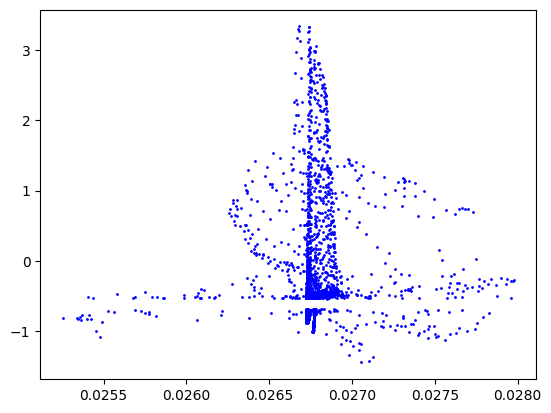

In [210]:
plt.plot(test_fold[3][0],test_fold[3][1],'bo',markersize = 1)
plt.show()
# len(test_fold[3][0]), len(test_fold[3][1])